# INDEX
* [Functions](#Functions)
* [Load datasets](#Load-datasets)
* [Configuration](#Configuration)
* [Baseline model](#Baseline-model)
* [LSTM model](#LSTM-model)
    * [Preprocess training data](#Preprocess-training-data)
    * [Train model](#Train-model)
    * [Test model](#Test-model)
    * [Predict](#Predict)
    * [Translate predictions](#Translate-predictions)

# Prerequisites

* go to parent root folder of off-category-classification
* execute download.sh

# Functions

In [1]:
import sys
sys.path.append('../') #append a relative path to the top package to the search path

In [2]:
# %load libtrain.py
import datetime
import functools
import json
import pathlib
import shutil
import tempfile
from typing import Dict, List

import dacite
import pandas as pd
import tensorflow as tf
from robotoff.taxonomy import Taxonomy
from tensorflow import keras
from tensorflow.data import Dataset
from tensorflow.keras import callbacks
from tensorflow.python.ops import summary_ops_v2

import settings
from category_classification.data_utils import (
    create_tf_dataset
)
from category_classification.models import (
    KerasPreprocessing,
    to_serving_model,
    build_model,
    construct_preprocessing
)

from category_classification.config import Config

from utils.io import (
    copy_category_taxonomy,
    save_category_vocabulary,
    save_config,
    save_json,
)
from utils.metrics import evaluation_report


#class TBCallback(callbacks.TensorBoard):
#    """Get around a bug where you cannot use the TensorBoard callback with the StringLookup layers
#    - https://github.com/tensorflow/tensorboard/issues/4530#issuecomment-783318292"""
#
#    def _log_weights(self, epoch):
#        with self._train_writer.as_default():
#            with summary_ops_v2.always_record_summaries():
#                for layer in self.model.layers:
#                    for weight in layer.weights:
#                        if hasattr(weight, "name"):
#                            weight_name = weight.name.replace(":", "_")
#                            summary_ops_v2.histogram(weight_name, weight, step=epoch)
#                            if self.write_images:
#                                self._log_weight_as_image(weight, weight_name, epoch)
#                self._train_writer.flush()


def train(
    model: keras.Model,
    save_dir: pathlib.Path,
    config: Config,
    category_vocab: List[str]
):
    print("Starting training...")
    temporary_log_dir = pathlib.Path(tempfile.mkdtemp())
    print("Temporary log directory: {}".format(temporary_log_dir))

    # for now, clear cache on each call to train(), to be safe
    cache_dir = pathlib.Path("tf_cache")
    shutil.rmtree(cache_dir, ignore_errors=True)
    cache_dir.mkdir()
    print("Cache directory: {}".format(cache_dir))

    train = (
        create_tf_dataset("train", category_vocab, config.train_config.batch_size)
        .cache(str(cache_dir / "train"))
    )
    val = (
        create_tf_dataset("val", category_vocab, config.train_config.batch_size)
        .cache(str(cache_dir / "val"))
    )


    history=model.fit(
        train,
        epochs= config.train_config.epochs,
        validation_data=val,
        callbacks=[
            callbacks.TerminateOnNaN(),
            callbacks.ModelCheckpoint(
                filepath=str(save_dir / "weights.{epoch:02d}-{val_loss:.4f}"),
                monitor="val_loss",
                save_best_only=True,
                save_format='tf',
            ),
            #TBCallback(log_dir=str(temporary_log_dir), histogram_freq=1),
            callbacks.EarlyStopping(monitor="val_loss", patience=4),
            callbacks.CSVLogger(str(save_dir / "training.log")),
            callbacks.History()
        ],
    )
    print("Training ended")
    return history

In [3]:
# replacement of category_classification.models.build_model

from category_classification.config import ModelConfig
from tensorflow.keras import layers

def create_model(config: Config, preprocess: KerasPreprocessing) -> keras.Model:
    model = build_model(config.model_config, preprocess)
    loss_fn = keras.losses.BinaryCrossentropy(
        label_smoothing=config.train_config.label_smoothing
    )
    optimizer = keras.optimizers.Adam(learning_rate=config.train_config.lr)
    model.compile(
        optimizer=optimizer,
        loss=loss_fn,
        metrics=["binary_accuracy", "Precision", "Recall"],
    )
    model.summary()
    return model

## Preprocessing functions
overriden & refactored functions in order  to plug to new dataset and remodel with chosen features

In [68]:
def tf_multihot_encode(vocab,ds,maxlen):
    """
    multi-encode a categorical pandas Series

    Parameters
    ----------
    vocab: vocabulary used to integer encode
    ds : categorical pandas Series
    maxlen : length of tensor (for padding)
    Returns
    -------
    vocab : vocabulary generated from ds
    tfdata : mult-hot encoded (based on vocab) tensor    
    """
    
    data =tf.keras.preprocessing.sequence.pad_sequences(ds,dtype=object,maxlen=maxlength,padding='post',value=" ") # make rectangular 
    
    integer_encode = tf.keras.layers.StringLookup(vocabulary=vocab)
    tfdata=integer_encode(data) # multi hot encode
    return tfdata

# Configuration

In [5]:
# load config json
import json
 
# Opening JSON file
with open('../config.json') as json_file:
    json_config = json.load(json_file)
json_config 

config=dacite.from_dict(Config, json_config)
model_config=config.model_config

output_dir:pathlib.Path = pathlib.Path("../models")
replicates = 1

output_dir.mkdir(parents=True, exist_ok=True)

# Load datasets

## New dataset

In [6]:
import settings

file_name = "predict_categories_dataset_products.jsonl"
input_file = settings.DATA_DIR / file_name
input_file

PosixPath('../data/predict_categories_dataset_products.jsonl')

In [7]:
%%time
import json
from time import sleep

data = []
with open(input_file, 'r') as f_in:
    for line in f_in:
        try:
            data.append(json.loads(line)) #‘json.loads’ decode a json object into a dictionary
        except:
            continue    # ignore lines where json throws an error

df = pd.DataFrame(data)

CPU times: user 1min 49s, sys: 31.1 s, total: 2min 20s
Wall time: 2min 26s


In [29]:
# filter nas values
dataset=df[df['product_name_en'].notna() & df['ingredients_tags'].notna()& df['categories_tags'].notna()]

In [30]:
# add legacy columns from new dataset
dataset['product_name']=dataset['product_name_en']
dataset['known_ingredient_tags']=dataset['ingredients_tags']

/var/folders/c7/w4lf4cp91_j_p3dxm9w00rmh0000gn/T/ipykernel_750/2852405796.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['product_name']=dataset['product_name_en']
/var/folders/c7/w4lf4cp91_j_p3dxm9w00rmh0000gn/T/ipykernel_750/2852405796.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['known_ingredient_tags']=dataset['ingredients_tags']


In [31]:
dataset.sample(8)

,ingredients_tags,categories_hierarchy,product_name_en,categories_properties,product_name_fr,code,ingredients_original_tags,images_not_found,categories_tags,product_name,...,ingredients_text_si,product_name_om,ingredients_text_om,ingredients_text_ps,product_name_ps,product_name_tl,ingredients_text_tl,product_name_mg,product_name_wo,known_ingredient_tags
493282,"[en:glucose-syrup, en:glucose, en:sugar, en:pa...","[en:snacks, en:sweet-snacks, en:confectionerie...",Blackcurrant amd Liquorice sweets,"{'agribalyse_food_code:en': '31003', 'ciqual_f...",NaN,5010251596646,"[en:glucose-syrup, en:sugar, en:palm-oil, en:s...",[],"[en:snacks, en:sweet-snacks, en:confectionerie...",Blackcurrant amd Liquorice sweets,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[en:glucose-syrup, en:glucose, en:sugar, en:pa..."
4833,"[en:whole-grain-non-gmo-pop-corn, en:corn-oil,...","[en:snacks, en:popcorn]",Microwave PopCorn - Butter Flavour,{'agribalyse_proxy_food_code:en': '9230'},Microwave Popcorn Parfumé au Beurre,0028190007876,"[en:whole grain non-gmo pop corn, en:corn-oil,...",[],"[en:snacks, en:popcorn]",Microwave PopCorn - Butter Flavour,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[en:whole-grain-non-gmo-pop-corn, en:corn-oil,..."
149851,"[en:sesame, en:seed, en:glucose-syrup, en:adde...","[en:snacks, en:sweet-snacks, en:biscuits-and-c...",,{'ciqual_food_code:en': '23900'},NaN,5201049250011,"[en:sesame, en:glucose-syrup, en:sugar, en:honey]",[],"[en:snacks, en:sweet-snacks, en:biscuits-and-c...",,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[en:sesame, en:seed, en:glucose-syrup, en:adde..."
643704,"[en:rocket, en:vegetable, en:salad]","[en:plant-based-foods-and-beverages, en:plant-...",Rucola,"{'agribalyse_food_code:en': '20217', 'ciqual_f...",NaN,20200114,[en:rocket],[],"[en:plant-based-foods-and-beverages, en:plant-...",Rucola,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[en:rocket, en:vegetable, en:salad]"
33522,"[en:sugar, en:added-sugar, en:disaccharide, en...","[en:snacks, en:sweet-snacks, en:confectioneries]","Torie & Howard, Hard Candy",{},NaN,0853715003183,"[en:sugar, en:rice-syrup, en:non-gmo citric ac...",[],"[en:snacks, en:sweet-snacks, en:confectioneries]","Torie & Howard, Hard Candy",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[en:sugar, en:added-sugar, en:disaccharide, en..."
9022,"[en:parboiled-brown-long-grain-rice, en:rice, ...","[en:plant-based-foods-and-beverages, en:plant-...",Natural Whole Grain Instant Brown Rice,{'agribalyse_proxy_food_code:en': '9101'},NaN,0041318300512,[en:parboiled-brown-long-grain-rice],[],"[en:plant-based-foods-and-beverages, en:plant-...",Natural Whole Grain Instant Brown Rice,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[en:parboiled-brown-long-grain-rice, en:rice, ..."
144203,[en:romanella-tomatoes],"[en:plant-based-foods-and-beverages, en:plant-...",Plum tomatoes,"{'agribalyse_food_code:en': '20047_3', 'ciqual...",NaN,5000169058008,[en:Romanella tomatoes],[],"[en:plant-based-foods-and-beverages, en:plant-...",Plum tomatoes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[en:romanella-tomatoes]
27223,"[en:tomato-puree, en:vegetable, en:tomato, en:...","[en:groceries, en:sauces, en:barbecue-sauces]",Carolina honeys barbecue sauce,"{'agribalyse_food_code:en': '11100', 'ciqual_f...",NaN,0698639020041,"[en:tomato-puree, en:sugar, en:distilled-vineg...",[],"[en:groceries, en:sauces, en:barbecue-sauces]",Carolina honeys barbecue sauce,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[en:tomato-puree, en:vegetable, en:tomato, en:..."


# Baseline model

# Preprocessing

In [44]:
from sklearn.model_selection import train_test_split

training_ds, testing_ds=train_test_split(dataset,test_size=0.3,random_state = 49)

In [45]:
model_config

ModelConfig(product_name_lstm_recurrent_dropout=0.2, product_name_lstm_dropout=0.0, product_name_embedding_size=64, product_name_lstm_units=64, product_name_max_length=30, product_name_max_tokens=93000, hidden_dim=64, hidden_dropout=0.2, category_min_count=10, ingredient_min_count=3)

Let's convert the categorical variables above into multi hot encoded tensors:

## Multi hot encode "categories_tags"

In [42]:
vocab_categories =list(set(dataset['categories_tags'].explode().dropna())) # vocabulary with unique values + filter out NAs

In [71]:
maxlength=max(map(len, dataset['categories_tags'].dropna()))
tf_categories_tags = tf_multihot_encode(vocab_categories,dataset['categories_tags'],maxlength)
len(vocab_categories),tf_categories_tags.shape,maxlength

(7910, TensorShape([104966, 43]), 43)

In [72]:
tf_categories_tags_train = tf_multihot_encode(vocab_categories,training_ds['categories_tags'],maxlength)
len(vocab_categories),tf_categories_tags_train.shape

(7910, TensorShape([73476, 43]))

In [73]:
tf_categories_tags_test = tf_multihot_encode(vocab_categories,testing_ds['categories_tags'],maxlength)
len(vocab_categories),tf_categories_tags_test.shape

(7910, TensorShape([31490, 43]))

## Multi hot encode "ingredients_tags"

In [74]:
vocab_ingredients =list(set(dataset['ingredients_tags'].explode().dropna())) # vocabulary with unique values + filter out NAs
maxlength=max(map(len, dataset['ingredients_tags'].dropna()))

In [75]:
tf_ingredients_tags_train=tf_multihot_encode(vocab_ingredients, training_ds['ingredients_tags'],maxlength)
len(vocab_ingredients),tf_ingredients_tags_train.shape,maxlength

(120010, TensorShape([73476, 318]), 318)

In [76]:
tf_ingredients_tags_test=tf_multihot_encode(vocab_ingredients, testing_ds['ingredients_tags'],maxlength)
len(vocab_ingredients),tf_ingredients_tags_test.shape

(120010, TensorShape([31490, 318]))

## Vectorizing 'product name'

In [53]:
tf_product_name_train=tf.constant(training_ds['product_name'].astype(str))
tf_product_name_train

<tf.Tensor: shape=(73476,), dtype=string, numpy=
array([b'Organic & fine grain coconut sugar', b'Meatlovers calzone',
       b'Celso Minussi', ..., b'4 aberdeen angus beef quarter pounders',
       b'North carolina style chicken & grits bowl, north carolina style',
       b'Kroger, roasted red pepper, vinaigrette dressing with parmesan'],
      dtype=object)>

In [60]:
tf_product_name_test=tf.constant(testing_ds['product_name'].astype(str))
tf_product_name_test

<tf.Tensor: shape=(31490,), dtype=string, numpy=
array([b'', b'Caffeine free fruit punch soda, fruit punch',
       b'Organic diced tomatoes in tomato juice', ...,
       b'Silvered almonds', b'Gardein, mini crispy crabless cakes',
       b'2 Chicken Quarter Pounders'], dtype=object)>

In [54]:
product_name_preprocessing = tf.keras.layers.TextVectorization(
    split="whitespace",
    max_tokens=model_config.product_name_max_tokens,
    output_sequence_length=model_config.product_name_max_length
)
product_name_preprocessing.adapt(tf_product_name, batch_size=50_000)

In [55]:
tf_product_name_vectorized_train=product_name_preprocessing(tf_product_name_train)
tf_product_name_vectorized_train.shape

TensorShape([73476, 30])

In [61]:
tf_product_name_vectorized_test=product_name_preprocessing(tf_product_name_test)
tf_product_name_vectorized_test.shape

TensorShape([31490, 30])

In [77]:
input_layer_train=layers.Concatenate()([tf_ingredients_tags_train,tf_product_name_vectorized_train])
input_layer_train.shape

TensorShape([73476, 348])

In [78]:
input_layer_test=layers.Concatenate()([tf_ingredients_tags_test,tf_product_name_vectorized_test])
input_layer_test.shape

TensorShape([31490, 348])

## Train model

In [79]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

baseline_model= tf.keras.models.Sequential([
    Dense(200,activation='relu'),
    Dense(200,activation='relu'),
    Dense(43,activation='softmax')
])

# compile
baseline_model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                      optimizer=Adam(),
                      metrics=['accuracy'])

# fit the model
history=baseline_model.fit(input_layer_train,
                           tf_categories_tags_train,
                           epochs=5,
                           validation_data=(input_layer_test, tf_categories_tags_test)
                          )

Epoch 1/5
2297/2297 [==============================] - 4s 1ms/step - loss: -204101040209920.0000 - accuracy: 0.4656 - val_loss: -760730781483008.0000 - val_accuracy: 0.4652
Epoch 2/5
2297/2297 [==============================] - 3s 1ms/step - loss: -2254922791780352.0000 - accuracy: 0.4661 - val_loss: -4353961624600576.0000 - val_accuracy: 0.4652
Epoch 3/5
2297/2297 [==============================] - 3s 1ms/step - loss: -7647203229171712.0000 - accuracy: 0.4661 - val_loss: -11780840816115712.0000 - val_accuracy: 0.4652
Epoch 4/5
2297/2297 [==============================] - 3s 1ms/step - loss: -17221749410103296.0000 - accuracy: 0.4661 - val_loss: -23807461135745024.0000 - val_accuracy: 0.4652
Epoch 5/5
2297/2297 [==============================] - 3s 1ms/step - loss: -31795307884838912.0000 - accuracy: 0.4661 - val_loss: -41327863244259328.0000 - val_accuracy: 0.4652


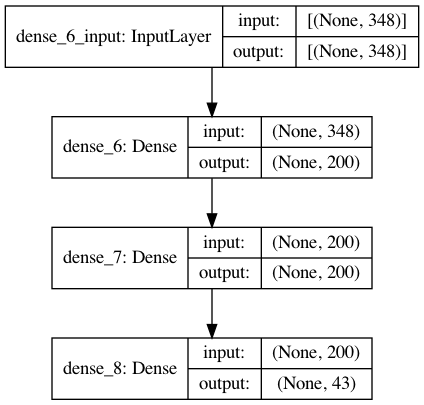

In [80]:
from keras.utils.vis_utils import plot_model

plot_model(baseline_model, show_shapes=True, show_layer_names=True)

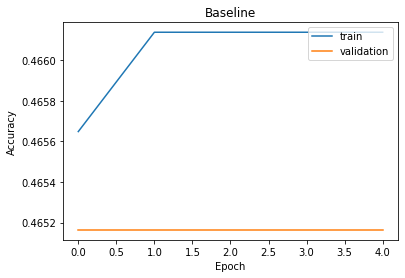

In [81]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Baseline')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train' , 'validation'] , loc = 'upper right')
plt.show()

# LSTM model

# Preprocess training data

In [86]:
%%time
keras_preprocess = construct_preprocessing(
    model_config.category_min_count,
    model_config.ingredient_min_count,
    model_config.product_name_max_tokens,
    model_config.product_name_max_length,
    training_ds,
)
print("Pre-processed training data")

Pre-processed training data
CPU times: user 855 ms, sys: 469 ms, total: 1.32 s
Wall time: 1.33 s


# Train model

In [55]:
model = create_model(config, keras_preprocess)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
product_name (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
text_vectorization_2 (TextVecto (None, 30)           0           product_name[0][0]               
__________________________________________________________________________________________________
ingredient (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 30, 64)       1256192     text_vectorization_2[0][0]       
______________________________________________________________________________________________

In [ ]:
%%time
import json

if replicates == 1:
    save_dirs = [output_dir]
else:
    save_dirs = [output_dir / str(i) for i in range(replicates)]

for i, save_dir in enumerate(save_dirs):
    model = create_model(config, keras_preprocess)
    save_dir.mkdir(exist_ok=True)
    config.train_config.start_datetime = str(datetime.datetime.utcnow())
    print(f"Starting training repeat {i}")

    save_config(config, save_dir)
    copy_category_taxonomy(settings.CATEGORY_TAXONOMY_PATH, save_dir)
    save_category_vocabulary(keras_preprocess.category_vocab, save_dir)
    # Get the dictionary containing each metric and the loss for each epoch
    train(
        model,
        save_dir,
        config,
        keras_preprocess.category_vocab,
    )

    config.train_config.end_datetime = str(datetime.datetime.utcnow())
    save_config(config, save_dir)
    config.train_config.start_datetime = None
    config.train_config.end_datetime = None

In [57]:
log_data = pd.read_csv('../models/training.log', sep=',', engine='python')
log_data

,epoch,binary_accuracy,loss,precision,recall,val_binary_accuracy,val_loss,val_precision,val_recall
0,0,0.996083,0.017123,0.552017,0.197942,0.997419,0.009105,0.871768,0.428440
1,1,0.997707,0.007939,0.839386,0.539489,0.998235,0.005875,0.885257,0.650025
2,2,0.998116,0.006282,0.858141,0.643999,0.998425,0.005209,0.887893,0.701299
3,3,0.998262,0.005748,0.864807,0.679289,0.998510,0.004931,0.891045,0.721916
4,4,0.998339,0.005472,0.868557,0.697120,0.998555,0.004789,0.890122,0.735400
5,5,0.998395,0.005284,0.871513,0.709063,0.998583,0.004698,0.887969,0.745583
6,6,0.998427,0.005157,0.873423,0.716907,0.998604,0.004642,0.891197,0.748116
7,7,0.998455,0.005063,0.875013,0.722793,0.998619,0.004594,0.889758,0.753772
8,8,0.998477,0.004978,0.876299,0.727833,0.998630,0.004562,0.890442,0.756342
9,9,0.998493,0.004918,0.877410,0.731489,0.998637,0.004538,0.889774,0.758879


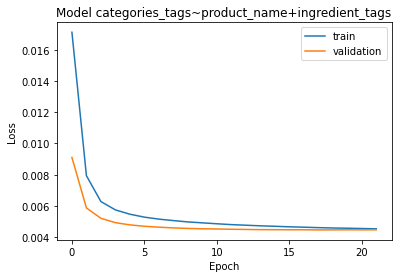

In [58]:
import matplotlib.pyplot as plt

plt.plot(log_data['epoch'],log_data['loss'])
plt.plot(log_data['epoch'],log_data['val_loss'])
plt.title('Model categories_tags~product_name+ingredient_tags')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train' , 'validation'] , loc = 'upper right')
plt.show()

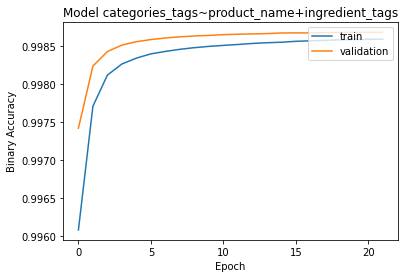

In [59]:
import matplotlib.pyplot as plt

plt.plot(log_data['epoch'],log_data['binary_accuracy'])
plt.plot(log_data['epoch'],log_data['val_binary_accuracy'])
plt.title('Model categories_tags~product_name+ingredient_tags')
plt.ylabel('Binary Accuracy')
plt.xlabel('Epoch')
plt.legend(['train' , 'validation'] , loc = 'upper right')
plt.show()

# Test model

In [82]:
# load saved model
model=keras.models.load_model('../models/base/saved_model')

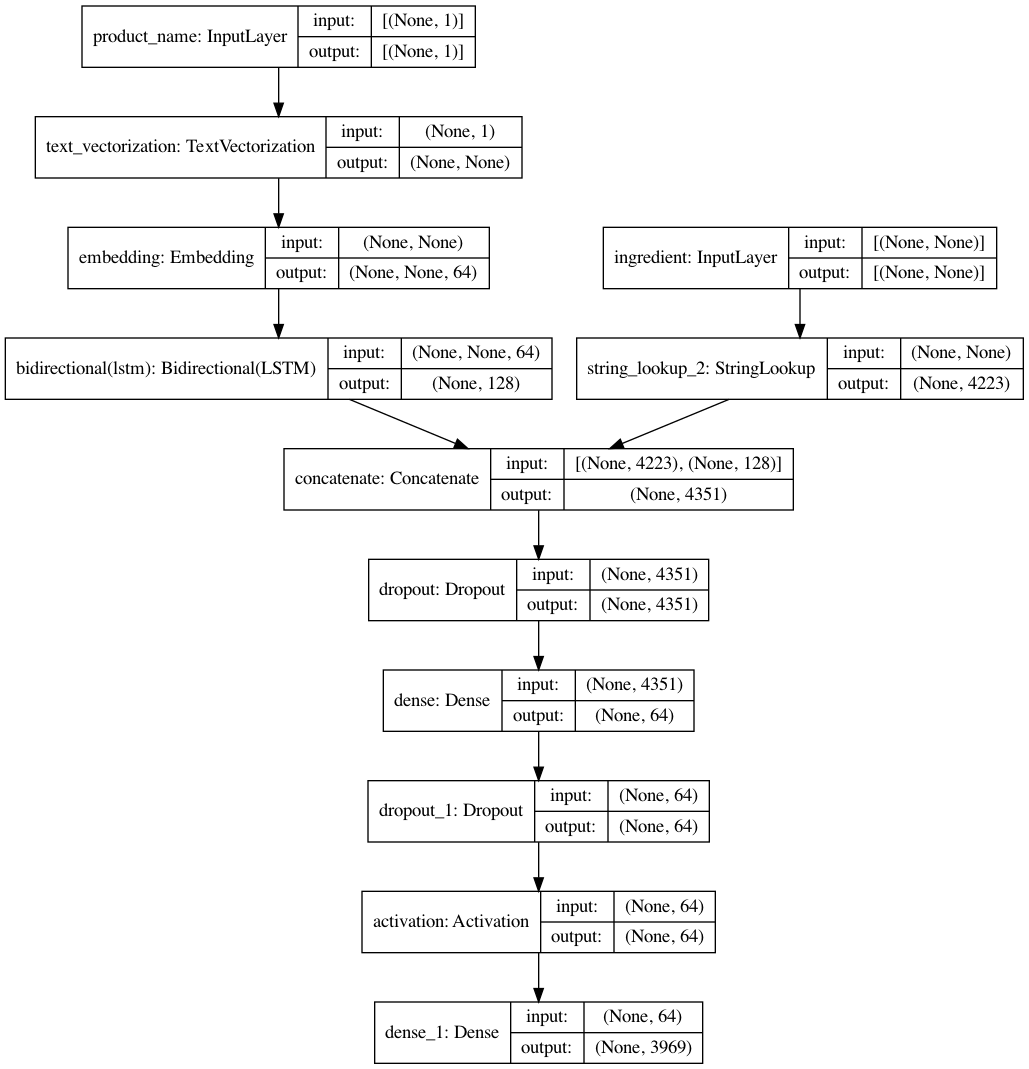

In [83]:
from keras.utils.vis_utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=True)

In [113]:
category_vocab = keras_preprocess.category_vocab
batch_size = config.train_config.batch_size

In [116]:
# Train & validation Dataset => investigate on characteristics of the source
valdata = create_tf_dataset("val", category_vocab, batch_size)
testdata = create_tf_dataset("test", category_vocab, batch_size)

In [117]:
# categories count
len(category_vocab)

1144

## Predict

In [90]:
%%time
y_pred_test = model.predict(testdata)

CPU times: user 54.4 s, sys: 22.9 s, total: 1min 17s
Wall time: 23.2 s


In [91]:
y_pred_test.shape

(87320, 3969)

In [92]:
y_pred_test

array([[1.1422783e-02, 2.9106607e-08, 1.8616578e-06, ..., 1.3573744e-10,
        1.6678333e-09, 1.1400034e-07],
       [1.9434567e-05, 6.0262022e-09, 4.3250511e-06, ..., 9.5710753e-18,
        1.8540440e-14, 8.8534751e-13],
       [9.8198652e-04, 5.3054283e-10, 1.0436243e-08, ..., 1.4927385e-14,
        1.0176477e-12, 1.2061078e-12],
       ...,
       [7.5667924e-01, 1.3700799e-11, 2.1688192e-12, ..., 2.8258068e-18,
        2.3219839e-16, 3.5128806e-13],
       [2.4676323e-04, 4.8964339e-14, 6.0147217e-12, ..., 1.8756643e-16,
        2.5486165e-15, 1.1011587e-15],
       [1.1568367e-03, 1.1596524e-05, 5.4461787e-05, ..., 1.3919157e-11,
        2.4204746e-13, 6.0214544e-10]], dtype=float32)

In [114]:
category_vocab

['en:plant-based-foods-and-beverages',
 'en:plant-based-foods',
 'en:snacks',
 'en:sweet-snacks',
 'en:beverages',
 'en:cereals-and-potatoes',
 'en:groceries',
 'en:dairies',
 'en:fruits-and-vegetables-based-foods',
 'en:biscuits-and-cakes',
 'en:sauces',
 'en:frozen-foods',
 'en:confectioneries',
 'en:cereals-and-their-products',
 'en:fermented-foods',
 'en:fermented-milk-products',
 'en:meals',
 'en:meats',
 'en:vegetables-based-foods',
 'en:plant-based-beverages',
 'en:canned-foods',
 'en:cheeses',
 'en:desserts',
 'en:biscuits',
 'en:spreads',
 'en:cocoa-and-its-products',
 'en:breakfasts',
 'en:breads',
 'en:frozen-desserts',
 'en:condiments',
 'en:canned-plant-based-foods',
 'en:prepared-meats',
 'en:cakes',
 'en:seafood',
 'en:fruits-based-foods',
 'en:fats',
 'en:legumes-and-their-products',
 'en:chocolate-candies',
 'en:sweet-spreads',
 'en:salty-snacks',
 'en:yogurts',
 'en:plant-based-spreads',
 'en:carbonated-drinks',
 'en:pastas',
 'en:salted-snacks',
 'en:appetizers',
 'e

## Translate predictions

In [118]:
import numpy as np

data=y_pred_test
NUMBER_OF_CATEGORIES = 4

values=np.partition(data,-NUMBER_OF_CATEGORIES) #top n probability values for each row
indices=np.argpartition(data,-NUMBER_OF_CATEGORIES) #top n probability values indices for each row

In [119]:
val=values[:,-NUMBER_OF_CATEGORIES:] # filter n first values for each row
ind=indices[:,-NUMBER_OF_CATEGORIES:] # filter n first values indices for each row

In [120]:
val

array([[0.16669801, 0.19374591, 0.3415661 , 0.23663446],
       [0.03449982, 0.9164026 , 0.9945315 , 0.99471736],
       [0.28645045, 0.3354592 , 0.3522381 , 0.9793534 ],
       ...,
       [0.75667924, 0.82109344, 0.9162159 , 0.8827714 ],
       [0.93086505, 0.9922839 , 0.9905559 , 0.9995463 ],
       [0.9801047 , 0.983957  , 0.9848249 , 0.9859791 ]], dtype=float32)

In [121]:
ind

array([[  89,  151,  593,   66],
       [ 710,  196,   48,   49],
       [  60,   62,   66,   11],
       ...,
       [   0,   11,   75,  209],
       [1396,  151, 1395,   89],
       [  15,  148,   12,   13]])

In [115]:
len(category_vocab)

1144

In [112]:
category_vocab[1396]

IndexError: list index out of range

In [103]:
dfPredictions=(pd.DataFrame(ind).applymap(lambda x:category_vocab[x])+": "+pd.DataFrame(np.round(val*100,2)).astype(str)+" %").reset_index()

IndexError: list index out of range

In [ ]:
# make dictionary from validation dataframe to get code ande product_name
dict_val=val_ds[['code','product_name']].to_dict()

In [ ]:
dfPredictions['product_name']=dfPredictions['index'].apply(lambda x:dict_val['product_name'][x])
dfPredictions['code']=dfPredictions['index'].apply(lambda x:dict_val['code'][x])
dfPredictions=dfPredictions.drop(columns=["index"])

In [ ]:
dfPredictions